# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [1]:
# pip install --upgrade pip

In [2]:
# pip install seaborn

In [3]:
# pip install catboost

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import seaborn as sb
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
# import xgboost
from lightgbm import LGBMClassifier

### 데이터 셋 읽어오기

In [6]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            15338 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  13756 non-null  float64
 8   id_strategic_ver         3444 non-null   float64
 9   it_strategic_ver         1121 non-null   float64
 10  idit_strategic_ver       4565 non-null   float64
 11  customer_job             40566 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             58358 non-null  object 
 14  product_category      

In [8]:
df_train = df_train.astype({ 'customer_country' : 'str' })
df_train = df_train.astype({ 'bant_submit' : 'str' })
df_train = df_train.astype({ 'customer_job' : 'str' })
df_train = df_train.astype({ 'customer_type' : 'str' })
df_train = df_train.astype({ 'expected_timeline' : 'str' })
df_train = df_train.astype({ 'ver_pro' : 'str' })
df_train = df_train.astype({ 'inquiry_type' : 'str' })
df_train = df_train.astype({ 'lead_owner' : 'str' })
df_train = df_train.astype({ 'product_category' : 'str' })
df_train = df_train.astype({ 'business_area' : 'str' })
# df_train = df_train.astype({ 'business_subarea' : 'str' })
df_train = df_train.astype({ 'is_converted' : 'bool' })

In [9]:
df_test = df_test.astype({ 'customer_country' : 'str' })
df_test = df_test.astype({ 'bant_submit' : 'str' })
df_test = df_test.astype({ 'customer_job' : 'str' })
df_test = df_test.astype({ 'customer_type' : 'str' })
df_test = df_test.astype({ 'customer_position' : 'str' })
df_test = df_test.astype({ 'expected_timeline' : 'str' })
df_test = df_test.astype({ 'id' : 'int' })
df_test = df_test.astype({ 'lead_owner' : 'str' })
df_test = df_test.astype({ 'ver_pro' : 'str' })
df_test = df_test.astype({ 'inquiry_type' : 'str' })
df_test = df_test.astype({ 'product_category' : 'str' })
df_test = df_test.astype({ 'business_area' : 'str' })
# df_test = df_test.astype({ 'business_subarea' : 'str' })
df_test = df_test.astype({ 'is_converted' : 'bool' })

In [10]:
# base
df_train = df_train.drop('customer_country.1', axis=1)
df_train = df_train.drop('product_modelname', axis=1)
df_train = df_train.drop('product_subcategory', axis=1)
df_train = df_train.drop('business_subarea', axis=1)
df_train = df_train.drop('customer_idx', axis=1)
# df_train = df_train.drop('lead_owner', axis=1)

df_test = df_test.drop('customer_country.1', axis=1)
df_test = df_test.drop('product_modelname', axis=1)
df_test = df_test.drop('product_subcategory', axis=1)
df_test = df_test.drop('business_subarea', axis=1)
df_test = df_test.drop('customer_idx', axis=1)

# try 1
# df_train = df_train.drop(['it_strategic_ver', 'ver_cus', 'ver_pro', 'idit_strategic_ver','id_strategic_ver'], axis =1)
# df_test = df_test.drop(['it_strategic_ver', 'ver_cus', 'ver_pro', 'idit_strategic_ver','id_strategic_ver'], axis =1)

# try 2
# df_train = df_train.drop(['ver_cus', 'ver_pro'], axis =1)
# df_test = df_test.drop(['ver_cus', 'ver_pro'], axis =1)

# try 3
# df_train = df_train.drop(['it_strategic_ver', 'idit_strategic_ver','id_strategic_ver'], axis =1)
# df_test = df_test.drop(['it_strategic_ver', 'idit_strategic_ver','id_strategic_ver'], axis =1)

In [11]:
print(df_train.isnull().sum())
# for column in df_train.columns:
#     df_train[column] = df_train[column].replace("nan", np.nan)
#     nan_count = df_train[column].isna().sum()
#     print(f"{column} 열의 NaN 값의 개수:", nan_count)
print(df_test.isnull().sum())

bant_submit                    0
customer_country               0
business_unit                  0
com_reg_ver_win_rate       44731
customer_type                  0
enterprise                     0
historical_existing_cnt    45543
id_strategic_ver           55855
it_strategic_ver           58178
idit_strategic_ver         54734
customer_job                   0
lead_desc_length               0
inquiry_type                   0
product_category               0
customer_position              0
response_corporate             0
expected_timeline              0
ver_cus                        0
ver_pro                        0
ver_win_rate_x             40882
ver_win_ratio_per_bu       43995
business_area                  0
lead_owner                     0
is_converted                   0
dtype: int64
id                            0
bant_submit                   0
customer_country              0
business_unit                 0
com_reg_ver_win_rate       3483
customer_type                 0
ent

## 2. 데이터 전처리

다시 학습 데이터와 제출 데이터를 분리합니다.

### 2-2. 학습, 검증 데이터 분리

In [12]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

# 레이블 인코딩할 칼럼들
label_columns = [
    "business_unit",
    "enterprise",
    "response_corporate"]

df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

for col in label_columns:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

In [13]:
df_train = df_train.fillna(0)
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  object 
 1   customer_country         59299 non-null  object 
 2   business_unit            59299 non-null  int64  
 3   com_reg_ver_win_rate     59299 non-null  float64
 4   customer_type            59299 non-null  object 
 5   enterprise               59299 non-null  int64  
 6   historical_existing_cnt  59299 non-null  float64
 7   id_strategic_ver         59299 non-null  float64
 8   it_strategic_ver         59299 non-null  float64
 9   idit_strategic_ver       59299 non-null  float64
 10  customer_job             59299 non-null  object 
 11  lead_desc_length         59299 non-null  int64  
 12  inquiry_type             59299 non-null  object 
 13  product_category         59299 non-null  object 
 14  customer_position     

In [14]:
for column in df_train.columns:
    if df_train[column].dtype != 'float64' and column != 'is_converted':
        try:
            df_train[column] = df_train[column].astype(str)
        except ValueError:
            pass

In [15]:
for column in df_test.columns:
    if df_test[column].dtype != 'float64' and column != 'is_converted':
        try:
            df_test[column] = df_test[column].astype(str)
        except ValueError:
            pass

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  object 
 1   customer_country         59299 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     59299 non-null  float64
 4   customer_type            59299 non-null  object 
 5   enterprise               59299 non-null  object 
 6   historical_existing_cnt  59299 non-null  float64
 7   id_strategic_ver         59299 non-null  float64
 8   it_strategic_ver         59299 non-null  float64
 9   idit_strategic_ver       59299 non-null  float64
 10  customer_job             59299 non-null  object 
 11  lead_desc_length         59299 non-null  object 
 12  inquiry_type             59299 non-null  object 
 13  product_category         59299 non-null  object 
 14  customer_position     

In [17]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    # print("오차행렬:\n", confusion)
    # print("\n정확도: {:.4f}".format(accuracy))
    # print("정밀도: {:.4f}".format(precision))
    # print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [18]:
from sklearn.preprocessing import RobustScaler
# 기존의 df_train 데이터프레임과 수치형 데이터만을 선택하여 새로운 데이터프레임 생성
numeric_cols_train = df_train.select_dtypes(include=['float64'])

# RobustScaler 객체 생성
robustScaler = RobustScaler()

# RobustScaler를 사용하여 학습 데이터에 대해 변환을 수행하고, 결과를 데이터프레임으로 변환
train_data_robustScaled = pd.DataFrame(robustScaler.fit_transform(numeric_cols_train), columns=numeric_cols_train.columns)

# 변환된 데이터와 기존의 데이터프레임을 합침
df_train_robustScaled = pd.concat([df_train.drop(columns=numeric_cols_train.columns), train_data_robustScaled], axis=1)

# 데이터프레임의 정보 확인
print(df_train_robustScaled.info())
df_train = df_train_robustScaled

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  object 
 1   customer_country         59299 non-null  object 
 2   business_unit            59299 non-null  object 
 3   customer_type            59299 non-null  object 
 4   enterprise               59299 non-null  object 
 5   customer_job             59299 non-null  object 
 6   lead_desc_length         59299 non-null  object 
 7   inquiry_type             59299 non-null  object 
 8   product_category         59299 non-null  object 
 9   customer_position        59299 non-null  object 
 10  response_corporate       59299 non-null  object 
 11  expected_timeline        59299 non-null  object 
 12  ver_cus                  59299 non-null  object 
 13  ver_pro                  59299 non-null  object 
 14  business_area         

In [19]:
# from sklearn.preprocessing import StandardScaler
#
# # 기존의 df_train 데이터프레임과 수치형 데이터만을 선택하여 새로운 데이터프레임 생성
# numeric_cols_train = df_train.select_dtypes(include=['float64'])
#
# # StandardScaler 객체 생성
# standardScaler = StandardScaler()
#
# # StandardScaler를 사용하여 학습 데이터에 대해 변환을 수행하고, 결과를 데이터프레임으로 변환
# train_data_standardScaled = pd.DataFrame(standardScaler.fit_transform(numeric_cols_train), columns=numeric_cols_train.columns)
#
# # 변환된 데이터와 기존의 데이터프레임을 합침
# df_train_standardScaled = pd.concat([df_train.drop(columns=numeric_cols_train.columns), train_data_standardScaled], axis=1)
#
# # 데이터프레임의 정보 확인
# print(df_train_standardScaled.info())
# df_train = df_train_standardScaled

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  object 
 1   customer_country         59299 non-null  object 
 2   business_unit            59299 non-null  object 
 3   customer_type            59299 non-null  object 
 4   enterprise               59299 non-null  object 
 5   customer_job             59299 non-null  object 
 6   lead_desc_length         59299 non-null  object 
 7   inquiry_type             59299 non-null  object 
 8   product_category         59299 non-null  object 
 9   customer_position        59299 non-null  object 
 10  response_corporate       59299 non-null  object 
 11  expected_timeline        59299 non-null  object 
 12  ver_cus                  59299 non-null  object 
 13  ver_pro                  59299 non-null  object 
 14  business_area         

In [21]:
# df_train = df_train.fillna(0)
uni = df_train['is_converted'].unique()

# for CatBoost
categorical_features_indices = np.where(df_train.drop("is_converted", axis=1).dtypes != float)[0]
print(len(categorical_features_indices))
print(categorical_features_indices)


16
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [22]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.35,
    shuffle=True,
    random_state=400,
)

print('After upsampling: \nX_train shape: {} \ny_train shape: {}'.format(x_train.shape, y_train.shape))

print(df_train['is_converted'].value_counts())

After upsampling: 
X_train shape: (38544, 23) 
y_train shape: (38544,)
is_converted
False    54449
True      4850
Name: count, dtype: int64


In [23]:
def bool_to_numeric(label):
    return int(label)

# y_train 및 y_val의 부울형 클래스 레이블을 숫자로 변환
y_train = y_train.apply(bool_to_numeric)
y_val = y_val.apply(bool_to_numeric)

In [24]:
# pip install --upgrade typing_extensions

In [25]:
# pip install optuna

In [26]:
# pip install catboost-cuda

In [27]:
# from sklearn.utils.class_weight import compute_class_weight
#
# classes = np.unique(y_train)
# weights = compute_class_weight(class_weight='balanced', classes = classes, y = y_train)
# class_weights = dict(zip(classes, weights))
# print(class_weights)

In [28]:
from random import randint
from scipy.stats import loguniform
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import random

import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
  param = {
      "eval_metric":"F1",
      "random_state":57,
      # "class_weights":class_weights,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.1, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 5000, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.1, 0.8),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-4,3e-2),
      "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
  }

  cat_features = categorical_features_indices
  cat = CatBoostClassifier(**param)
  cat.fit(x_train, y_train,
          eval_set=[(x_train, y_train), (x_val,y_val)],
          early_stopping_rounds=100,cat_features=cat_features,
          verbose=100)

  # cat_pred = cat.predict_proba(x_val)
  # log_score = log_loss(y_val, cat_pred)


  cat_pred = cat.predict(x_val)
  # cat_pred = np.where(cat_pred == 'True', True, False)
  result = f1_score(y_val, cat_pred)
  # y_pred = np.argmax(cat_pred, axis=1)
  # result = roc_auc_score(y_val, y_pred)

  return result


sampler = TPESampler(seed=57)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'maximize',
    sampler = sampler,
)
study.optimize(objective, n_trials=5)
# print("Best Score:",study.best_value)
# print("Best trial",study.best_trial.params)

[I 2024-02-21 23:26:23,184] A new study created in memory with name: cat_parameter_opt


0:	learn: 0.1723267	test: 0.1651430	test1: 0.1544079	best: 0.1544079 (0)	total: 326ms	remaining: 38m 21s


[I 2024-02-21 23:26:34,168] Trial 0 finished with value: 0.15440792905581638 and parameters: {'learning_rate': 0.013459409731446636, 'bagging_temperature': 0.49139563983400064, 'n_estimators': 7055, 'max_depth': 8, 'random_strength': 57, 'colsample_bylevel': 0.4815445926486954, 'l2_leaf_reg': 0.024232273340628264, 'min_child_samples': 92, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.15440792905581638.


100:	learn: 0.0070468	test: 0.0095969	test1: 0.0193622	best: 0.1544079 (0)	total: 9.89s	remaining: 11m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1544079291
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 70.2ms	remaining: 9m 15s
100:	learn: 0.6694387	test: 0.8813041	test1: 0.6514898	best: 0.6514898 (100)	total: 8.02s	remaining: 10m 20s
200:	learn: 0.7577955	test: 0.9135720	test1: 0.6712373	best: 0.6747621 (185)	total: 17.6s	remaining: 11m 14s
300:	learn: 0.8069925	test: 0.9173333	test1: 0.6699378	best: 0.6766917 (245)	total: 27.7s	remaining: 11m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6766917293
bestIteration = 245

Shrink model to first 246 iterations.


[I 2024-02-21 23:27:07,190] Trial 1 finished with value: 0.6766917293233082 and parameters: {'learning_rate': 0.21243988741050715, 'bagging_temperature': 1.826171152883385, 'n_estimators': 7911, 'max_depth': 6, 'random_strength': 45, 'colsample_bylevel': 0.4275046630697321, 'l2_leaf_reg': 0.0031090509924157, 'min_child_samples': 93, 'max_bin': 248, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6766917293233082.


0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 62ms	remaining: 7m 14s
100:	learn: 0.6617758	test: 0.8710274	test1: 0.6532231	best: 0.6563325 (70)	total: 7.3s	remaining: 8m 19s
200:	learn: 0.7026529	test: 0.9136703	test1: 0.6692862	best: 0.6703801 (185)	total: 14.9s	remaining: 8m 23s
300:	learn: 0.7313786	test: 0.9231024	test1: 0.6797002	best: 0.6852874 (267)	total: 22.3s	remaining: 8m 17s


[I 2024-02-21 23:27:35,367] Trial 2 finished with value: 0.6852874309840857 and parameters: {'learning_rate': 0.2922249166862817, 'bagging_temperature': 0.20674830014480472, 'n_estimators': 7010, 'max_depth': 4, 'random_strength': 1, 'colsample_bylevel': 0.6049199028147242, 'l2_leaf_reg': 0.0013398293689034794, 'min_child_samples': 2, 'max_bin': 224, 'od_type': 'Iter'}. Best is trial 2 with value: 0.6852874309840857.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.685287431
bestIteration = 267

Shrink model to first 268 iterations.
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 32.3ms	remaining: 4m 29s
100:	learn: 0.0191022	test: 0.0278922	test1: 0.0316921	best: 0.0316921 (97)	total: 12.5s	remaining: 16m 58s
200:	learn: 0.1431127	test: 0.2342598	test1: 0.1314805	best: 0.1324786 (198)	total: 24.6s	remaining: 16m 36s
300:	learn: 0.3034893	test: 0.5086925	test1: 0.3212435	best: 0.3212435 (296)	total: 40.1s	remaining: 17m 52s
400:	learn: 0.4041216	test: 0.5889187	test1: 0.4175729	best: 0.4175729 (400)	total: 53.8s	remaining: 17m 46s
500:	learn: 0.4464847	test: 0.6526628	test1: 0.4551201	best: 0.4553120 (492)	total: 1m 5s	remaining: 17m 12s
600:	learn: 0.4759887	test: 0.6986525	test1: 0.4773289	best: 0.4773289 (600)	total: 1m 18s	remaining: 16m 53s
700:	learn: 0.5005751	test: 0.7266920	test1: 0.4926948	best: 0.4926948 (699)	total: 1m 31s	remaining: 1

[I 2024-02-21 23:33:06,547] Trial 3 finished with value: 0.6714677640603567 and parameters: {'learning_rate': 0.010694096783308375, 'bagging_temperature': 2.4266307154451696, 'n_estimators': 8348, 'max_depth': 12, 'random_strength': 80, 'colsample_bylevel': 0.15860417027180376, 'l2_leaf_reg': 0.026856730858056656, 'min_child_samples': 79, 'max_bin': 399, 'od_type': 'IncToDec'}. Best is trial 2 with value: 0.6852874309840857.


0:	learn: 0.0006427	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 125ms	remaining: 15m 43s
100:	learn: 0.0409191	test: 0.0658794	test1: 0.0602342	best: 0.0602342 (100)	total: 9.16s	remaining: 11m 14s
200:	learn: 0.3492638	test: 0.5018904	test1: 0.3794183	best: 0.3794183 (200)	total: 18.8s	remaining: 11m 25s
300:	learn: 0.4246641	test: 0.5939208	test1: 0.4459346	best: 0.4459346 (300)	total: 28s	remaining: 11m 12s
400:	learn: 0.4686924	test: 0.6597981	test1: 0.4854369	best: 0.4854369 (399)	total: 37.4s	remaining: 11m 4s
500:	learn: 0.4939705	test: 0.6999604	test1: 0.5152941	best: 0.5152941 (500)	total: 46.5s	remaining: 10m 53s
600:	learn: 0.5223816	test: 0.7404566	test1: 0.5424116	best: 0.5429658 (593)	total: 56.1s	remaining: 10m 47s
700:	learn: 0.5761231	test: 0.7970306	test1: 0.5819106	best: 0.5819106 (700)	total: 1m 6s	remaining: 10m 51s
800:	learn: 0.6374926	test: 0.8772287	test1: 0.6251305	best: 0.6251305 (800)	total: 1m 19s	remaining: 11m 4s
900:	learn: 0.6754200	test

[I 2024-02-21 23:36:14,707] Trial 4 finished with value: 0.6918528252299606 and parameters: {'learning_rate': 0.01957443402101589, 'bagging_temperature': 4.131692533156464, 'n_estimators': 7536, 'max_depth': 7, 'random_strength': 67, 'colsample_bylevel': 0.6119501335010737, 'l2_leaf_reg': 0.02081214862296549, 'min_child_samples': 60, 'max_bin': 259, 'od_type': 'IncToDec'}. Best is trial 4 with value: 0.6918528252299606.


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [41]:
optuna.visualization.plot_param_importances(study)

In [42]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
best_params = study.best_trial.params
best_params["eval_metric"] = 'F1'
best_params["random_state"] = 57
# best_cat = CatBoostClassifier(task_type="GPU", **best_params)
best_cat = CatBoostClassifier(**best_params)
best_cat.fit(x_train, y_train,
             eval_set=[(x_val, y_val)],
             early_stopping_rounds=100,
             cat_features=categorical_features_indices,
             verbose=100)


y_pred = best_cat.predict(x_val)
y_pred_bool = np.where(y_pred == 'True', True, False)
print(y_pred)

get_clf_eval(y_val, y_pred)

0:	learn: 0.0006427	test: 0.0000000	best: 0.0000000 (0)	total: 254ms	remaining: 31m 54s
100:	learn: 0.0409191	test: 0.0602342	best: 0.0602342 (100)	total: 12.1s	remaining: 14m 49s
200:	learn: 0.3492638	test: 0.3794183	best: 0.3794183 (200)	total: 24s	remaining: 14m 35s
300:	learn: 0.4246641	test: 0.4459346	best: 0.4459346 (300)	total: 34.4s	remaining: 13m 47s
400:	learn: 0.4686924	test: 0.4854369	best: 0.4854369 (399)	total: 45.2s	remaining: 13m 23s
500:	learn: 0.4939705	test: 0.5152941	best: 0.5152941 (500)	total: 56.9s	remaining: 13m 19s


In [31]:
import catboost

In [32]:
feature_importance = best_cat.get_feature_importance(data=catboost.Pool(data=x_train, label=y_train, cat_features=categorical_features_indices), type='FeatureImportance')

# 각 특성에 대한 중요도를 출력합니다.
for i, score in enumerate(feature_importance):
    print(f'Feature {i}: {score}')

Feature 0: 2.9416803160629277
Feature 1: 2.5898049987668474
Feature 2: 2.5146425969868655
Feature 3: 5.74656138827377
Feature 4: 1.6672898500776945
Feature 5: 5.07231157560386
Feature 6: 8.024620488039126
Feature 7: 7.760590202465571
Feature 8: 6.208947779009367
Feature 9: 2.4498614244539407
Feature 10: 6.628666894689248
Feature 11: 2.380133099077461
Feature 12: 0.3459969367677758
Feature 13: 0.38243968135189094
Feature 14: 4.564382199521615
Feature 15: 23.361021861301392
Feature 16: 3.702970695237982
Feature 17: 9.04019812001144
Feature 18: 0.14028071372222578
Feature 19: 0.3297743029930317
Feature 20: 0.5484069893994463
Feature 21: 1.8111169158865874
Feature 22: 1.7883009702999453


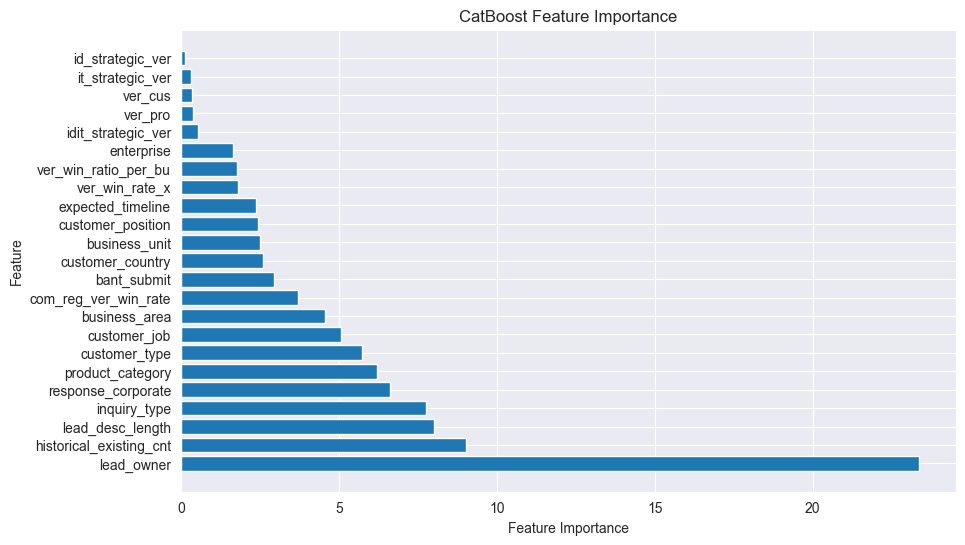

In [33]:

import matplotlib.pyplot as plt

# 특성의 중요도를 추출합니다.
feature_importance = best_cat.get_feature_importance(data=catboost.Pool(data=x_train, label=y_train, cat_features=categorical_features_indices), type='FeatureImportance')

# 특성의 이름을 가져옵니다.
feature_names = x_train.columns

# 중요도와 특성 이름을 연결합니다.
feature_importance_dict = dict(zip(feature_names, feature_importance))

# 중요도를 기준으로 내림차순으로 정렬합니다.
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 시각화를 위해 특성 중요도를 추출합니다.
sorted_features = [x[0] for x in sorted_feature_importance]
sorted_importances = [x[1] for x in sorted_feature_importance]

# 중요도를 막대 그래프로 시각화합니다.
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance')
plt.show()

In [34]:
print(sorted_feature_importance)

[('lead_owner', 23.361021861301392), ('historical_existing_cnt', 9.04019812001144), ('lead_desc_length', 8.024620488039126), ('inquiry_type', 7.760590202465571), ('response_corporate', 6.628666894689248), ('product_category', 6.208947779009367), ('customer_type', 5.74656138827377), ('customer_job', 5.07231157560386), ('business_area', 4.564382199521615), ('com_reg_ver_win_rate', 3.702970695237982), ('bant_submit', 2.9416803160629277), ('customer_country', 2.5898049987668474), ('business_unit', 2.5146425969868655), ('customer_position', 2.4498614244539407), ('expected_timeline', 2.380133099077461), ('ver_win_rate_x', 1.8111169158865874), ('ver_win_ratio_per_bu', 1.7883009702999453), ('enterprise', 1.6672898500776945), ('idit_strategic_ver', 0.5484069893994463), ('ver_pro', 0.38243968135189094), ('ver_cus', 0.3459969367677758), ('it_strategic_ver', 0.3297743029930317), ('id_strategic_ver', 0.14028071372222578)]


## 4. 제출하기

In [35]:
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
# folds = []
# for train_idx, valid_idx in skf.split(df_train, df_train['is_converted']):
#   folds.append((train_idx,valid_idx))

In [36]:
# random.seed(44)
# cat_models={}
#
# cat_features = categorical_features_indices
# df_train = df_train.fillna(0)
# for fold in range(5):
#   print(f'===================================={fold+1}============================================')
#   train_idx, valid_idx = folds[fold]
#   X_train = df_train.drop(['is_converted'],axis=1).iloc[train_idx].values
#   X_valid = df_train.drop(['is_converted'],axis=1).iloc[valid_idx].values
#   y_train = df_train['is_converted'][train_idx].values
#   y_valid = df_train['is_converted'][valid_idx].values
#
#   cat = CatBoostClassifier(**study.best_params)
#   cat.fit(X_train, y_train,
#           eval_set=[(X_train, y_train), (X_valid,y_valid)],
#           early_stopping_rounds=35,cat_features=cat_features,
#           verbose=100)
#   cat_models[fold] = cat
#   print(f'================================================================================\n\n')

In [45]:
df_test = df_test.drop(["is_converted", "id"], axis=1)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              5271 non-null   object 
 1   customer_country         5271 non-null   object 
 2   business_unit            5271 non-null   object 
 3   com_reg_ver_win_rate     1788 non-null   float64
 4   customer_type            5271 non-null   object 
 5   enterprise               5271 non-null   object 
 6   historical_existing_cnt  1275 non-null   float64
 7   id_strategic_ver         593 non-null    float64
 8   it_strategic_ver         53 non-null     float64
 9   idit_strategic_ver       646 non-null    float64
 10  customer_job             5271 non-null   object 
 11  lead_desc_length         5271 non-null   object 
 12  inquiry_type             5271 non-null   object 
 13  product_category         5271 non-null   object 
 14  customer_position       

In [46]:
df_test = df_test.fillna(0)
# numeric_cols_test = df_test.select_dtypes(include=['float64'])
# print(numeric_cols_test)
# print(numeric_cols_train)
# # 학습 데이터에서 사용한 RobustScaler 객체를 사용하여 테스트 데이터에 대해 변환을 수행
# test_data_robustScaled = pd.DataFrame(robustScaler.transform(numeric_cols_test), columns=numeric_cols_test.columns)
# # test_data_robustScaled = pd.DataFrame(standardScaler.transform(numeric_cols_test), columns=numeric_cols_test.columns)
# # 변환된 데이터와 기존의 데이터프레임을 합침
# df_test_robustScaled = pd.concat([df_test.drop(columns=numeric_cols_test.columns), test_data_robustScaled], axis=1)
#
# # 데이터프레임의 정보 확인
# print(df_test_robustScaled.info())
# df_test = df_test_robustScaled

In [39]:
  # 테스트 데이터의 결측치 처리
# # X_test = df_test.drop(['is_converted', 'id'], axis=1).values
# X_test = df_test.values

In [40]:
# test_predictions = np.zeros((X_test.shape[0], len(cat_models)))
#
# for fold, cat in cat_models.items():
#     test_predictions[:, fold] = cat.predict_proba(X_test)[:, 1]  # 양성 클래스에 대한 확률
#
# # 각 fold에서의 예측 결과의 평균을 최종 예측 결과로 사용
# final_predictions = np.mean(test_predictions, axis=1)
# final_labels = (final_predictions > 0.5).astype(int)
# sum(final_labels)

### 테스트 데이터 예측

In [41]:
# 예측에 필요한 데이터 분리
# x_test = df_test.drop(["is_converted", "id"], axis=1)
# x_test = df_test.drop(["is_converted"], axis=1)

In [42]:

# df_test['lead_owner'] = df_test['lead_owner'].astype('str')
# x_test.info()

In [52]:
test_pred = best_cat.predict(df_test)

pred_bool = np.where(test_pred == 'True', True, False)
# sum(pred_bool) # True로 예측된 개수
sum(test_pred)
# print(pred_bool)

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=3]=0.0732484076433121 : cat_features must be integer or string, real number values and NaN values should be converted to string.

### 제출 파일 작성

In [38]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**